In [122]:
import sys
print(sys.executable)

/usr/bin/python3


### Import des bibliothèques

In [123]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
# Initialiser Spark avec le connecteur Cassandra
spark = SparkSession.builder \
    .appName("Clustering with PySpark") \
    .config("spark.cassandra.connection.host", "172.18.0.2") \
    .config("spark.cassandra.connection.port", "9042") \
    .config("spark.cassandra.auth.username", "cassandra") \
    .config("spark.cassandra.auth.password", "cassandra") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.2.0") \
    .getOrCreate()

### Chargement des données 

In [125]:
# Charger les données depuis Cassandra
catalogue = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="catalogue", keyspace="concessionnaire") \
    .load()

immatriculations = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="immatriculation", keyspace="concessionnaire") \
    .load()

### Prétraitement des données

In [126]:
# Afficher les premières lignes
print("Aperçu des données du catalogue :")
catalogue.show(5)

Aperçu des données du catalogue :
+--------------+-------+--------+----------+--------+--------+--------+--------------------+---------+
|           nom|couleur|longueur|    marque|nbplaces|nbportes|occasion|                prix|puissance|
+--------------+-------+--------+----------+--------+--------+--------+--------------------+---------+
|New Beatle 1.8|  rouge| moyenne|Volkswagen|       5|       5|   false|26630.00000000000...|      110|
|          A200|  rouge| moyenne|  Mercedes|       5|       5|   false|25900.00000000000...|      136|
|  Golf 2.0 FSI|  rouge| moyenne|Volkswagen|       5|       5|   false|22900.00000000000...|      150|
|     Cuore 1.0|  rouge|  courte|  Daihatsu|       5|       3|   false|8850.000000000000...|       58|
|      1007 1.4|  rouge|  courte|   Peugeot|       5|       5|   false|13750.00000000000...|       75|
+--------------+-------+--------+----------+--------+--------+--------+--------------------+---------+
only showing top 5 rows



25/01/19 12:58:53 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [127]:
catalogue.count()

25/01/19 12:58:54 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


32

In [129]:
# Encodage ordinal de la colonne 'longueur'
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="longueur", outputCol="longueur_index", stringOrderType="alphabetAsc")
catalogue_new = indexer.fit(catalogue_new).transform(catalogue_new)

25/01/19 12:59:03 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [130]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ["puissance", "longueur_index", "nbplaces", "nbportes", "prix"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
catalogue_new = assembler.transform(catalogue_new)

In [131]:
# Normalisation des données
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(catalogue_new)
catalogue_new = scaler_model.transform(catalogue_new)

25/01/19 12:59:09 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [132]:
catalogue_new.show(3)

25/01/19 12:59:11 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+--------+-------+--------+-------+--------+--------+--------+--------------------+---------+--------------+--------------------+--------------------+
|     nom|couleur|longueur| marque|nbplaces|nbportes|occasion|                prix|puissance|longueur_index|            features|     scaled_features|
+--------+-------+--------+-------+--------+--------+--------+--------------------+---------+--------------+--------------------+--------------------+
|1007 1.4|  rouge|  courte|Peugeot|       5|       5|   false|13750.00000000000...|       75|           0.0|[75.0,0.0,5.0,5.0...|[-0.8685768029797...|
|    120i|  rouge| moyenne|    BMW|       5|       5|   false|35800.00000000000...|      150|           2.0|[150.0,2.0,5.0,5....|[-0.0124846768395...|
|9.3 1.8T|  rouge|  longue|   Saab|       5|       5|   false|38600.00000000000...|      150|           1.0|[150.0,1.0,5.0,5....|[-0.0124846768395...|
+--------+-------+--------+-------+--------+--------+--------+--------------------+---------+-

In [133]:
catalogue_new.count()

25/01/19 12:59:14 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


32

### Clustering

In [134]:
# Clustering avec KMeans
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=123)
model = kmeans.fit(catalogue_new)
catalogue_new = model.transform(catalogue_new)

25/01/19 12:59:15 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:15 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:16 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:17 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [135]:
# Afficher les clusters
print("Résultats du clustering :")
catalogue_new.select("marque", "nom", "puissance", "prix", "prediction").show()

Résultats du clustering :


25/01/19 12:59:17 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+----------+--------------+---------+--------------------+----------+
|    marque|           nom|puissance|                prix|prediction|
+----------+--------------+---------+--------------------+----------+
|   Peugeot|      1007 1.4|       75|13750.00000000000...|         0|
|       BMW|          120i|      150|35800.00000000000...|         0|
|      Saab|      9.3 1.8T|      150|38600.00000000000...|         0|
|      Audi|        A2 1.4|       75|18310.00000000000...|         0|
|  Mercedes|          A200|      136|25900.00000000000...|         0|
|      Audi|    A3 2.0 FSI|      150|28500.00000000000...|         0|
|    Nissan|    Almera 1.8|      115|16450.00000000000...|         0|
|      Mini|Copper 1.6 16V|      115|18200.00000000000...|         0|
|      Fiat|     Croma 2.2|      147|24780.00000000000...|         0|
|  Daihatsu|     Cuore 1.0|       58|8850.000000000000...|         2|
|   Renault|   Espace 2.0T|      165|30350.00000000000...|         1|
|     Honda|      FR

25/01/19 12:59:18 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


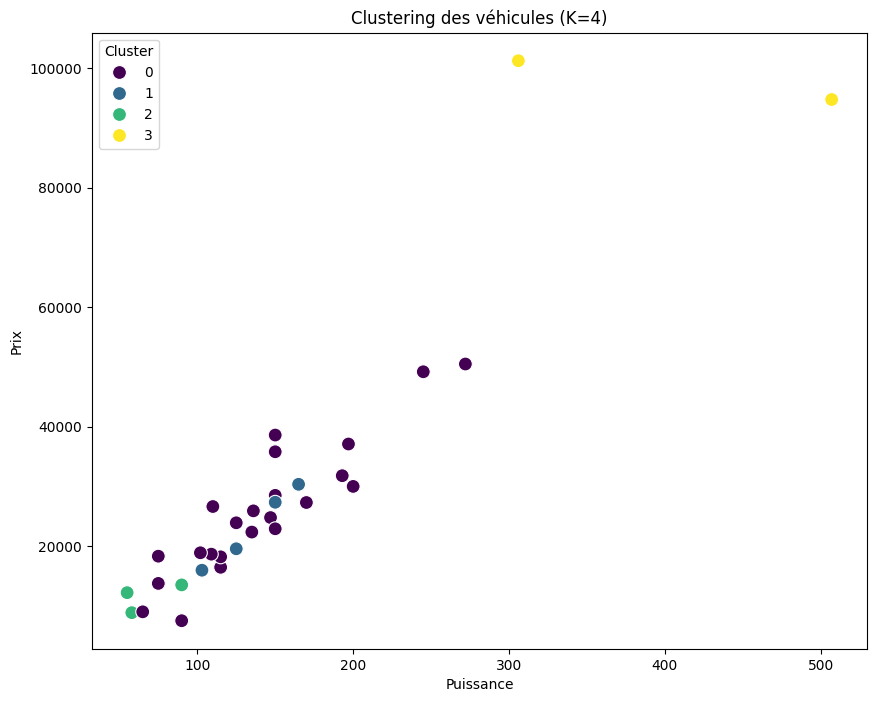

In [136]:
# Visualisation des clusters (nécessite la conversion en Pandas)
catalogue_new_pd = catalogue_new.select("puissance", "prix", "prediction").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(x="puissance", y="prix", hue="prediction", data=catalogue_new_pd, palette="viridis", s=100)
plt.title("Clustering des véhicules (K=4)")
plt.xlabel("Puissance")
plt.ylabel("Prix")
plt.legend(title="Cluster")
plt.show()

In [137]:
# Sélectionner uniquement les colonnes nécessaires pour la sauvegarde
columns_to_save = ["marque", "nom", "couleur", "puissance", "longueur", "nbplaces", "nbportes", "prix", "prediction"]
catalogue_new_selected = catalogue_new.select(columns_to_save)

# Sauvegarder les données avec les clusters
catalogue_new_selected.write.csv("data/clustered/catalogue_clusters.csv", header=True, mode="overwrite")

25/01/19 12:59:19 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [138]:
# CREATE TABLE concessionnaire.catalogue_clusters (
#     marque text,
#     nom text,
#     couleur text,
#     puissance int,
#     longueur text,
#     nbplaces int,
#     nbportes int,
#     prix decimal,
#     prediction int,
#     PRIMARY KEY (marque, nom, couleur)
# );

In [139]:
# Sauvegarder les données avec les clusters dans Cassandra 
catalogue_new_selected.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="catalogue_clusters", keyspace="concessionnaire") \
    .mode("append") \
    .save()
print("Données sauvegardées avec succès dans Cassandra.")

25/01/19 12:59:22 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


Données sauvegardées avec succès dans Cassandra.


#### Ajouter les clusters à immatriculations

In [140]:
# Fusionner les clusters du catalogue avec les immatriculations
catalogue_clusters = catalogue_new.select("marque", "nom", "prediction")
immatriculations_with_clusters = immatriculations.join(catalogue_clusters, on=["marque", "nom"], how="left")

In [141]:
immatriculations_with_clusters.count()

25/01/19 12:59:31 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


99989

In [142]:
# Filtrer les immatriculations pour ne garder que les voitures neuves
immatriculations_with_clusters = immatriculations_with_clusters.filter(col("occasion") == False)

In [143]:
immatriculations_with_clusters.show()

25/01/19 12:59:35 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:35 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+-------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
| marque|             nom|immatriculation|couleur|   longueur|nbplaces|nbportes|occasion|                prix|puissance|prediction|
+-------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
| Jaguar|   X-Type 2.5 V6|     3969 CA 63|  blanc|     longue|       5|       5|   false|37100.00000000000...|      197|         0|
| Jaguar|   X-Type 2.5 V6|     7127 SW 75|   gris|     longue|       5|       5|   false|37100.00000000000...|      197|         0|
| Jaguar|   X-Type 2.5 V6|     2367 VH 95|  rouge|     longue|       5|       5|   false|37100.00000000000...|      197|         0|
| Jaguar|   X-Type 2.5 V6|     8560 YF 60|   gris|     longue|       5|       5|   false|37100.00000000000...|      197|         0|
| Jaguar|   X-Type 2.5 V6|     9394 AE 32|  blanc|     longue|       5|     

In [144]:
# Sauvegarder les immatriculations avec les clusters
immatriculations_with_clusters.write.csv("data/clustered/immatriculations_clusters.csv", header=True, mode="overwrite")

25/01/19 12:59:42 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:42 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [145]:

# CREATE TABLE concessionnaire.immatriculations_clusters (
#     immatriculation text PRIMARY KEY,
#     marque text,
#     nom text,
#     couleur text,
#     puissance int,
#     longueur text,
#     nbplaces int,
#     nbportes int,
#     occasion boolean,
#     prix decimal,
#     prediction int
# );

In [146]:
# Sauvegarder les données avec les clusters dans Cassandra 
immatriculations_with_clusters.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="immatriculations_clusters", keyspace="concessionnaire") \
    .mode("append") \
    .save()
print("Données sauvegardées avec succès dans Cassandra.")

25/01/19 12:59:46 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:46 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


Données sauvegardées avec succès dans Cassandra.


In [147]:

# Afficher les premières lignes des immatriculations avec les clusters
print("Aperçu des immatriculations avec les clusters :")
immatriculations_with_clusters.show(5)

25/01/19 12:59:59 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 12:59:59 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


Aperçu des immatriculations avec les clusters :
+--------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
|  marque|             nom|immatriculation|couleur|   longueur|nbplaces|nbportes|occasion|                prix|puissance|prediction|
+--------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
|     Kia|     Picanto 1.1|     2299 PE 95|  rouge|     courte|       5|       5|   false|8990.000000000000...|       65|         0|
|  Jaguar|   X-Type 2.5 V6|      400 KG 82|  rouge|     longue|       5|       5|   false|37100.00000000000...|      197|         0|
| Renault|Vel Satis 3.5 V6|      891 HS 34|   gris|très longue|       5|       5|   false|49200.00000000000...|      245|         0|
|Daihatsu|       Cuore 1.0|     7046 ON 84|   bleu|     courte|       5|       3|   false|8850.000000000000...|       58|         2|
|    Audi|          A

25/01/19 13:31:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1482617 ms exceeds timeout 120000 ms
25/01/19 13:31:33 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/19 13:31:37 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 